In [1]:
from keras.applications import inception_v3
from keras import backend as K

# This setting disables all training specific operations
K.set_learning_phase(0)

# Load InceptionV3
model = inception_v3.InceptionV3(weights = 'imagenet', include_top = False)


C:\Users\neonalliance\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


87916544/87910968 [==============================] - 58s 1us/step


In [2]:
layer_contributions = {
    'mixed2': 0.7,
    'mixed3': 2.2,
    'mixed4': 1.2,
    'mixed5': .2,
}

In [3]:
# Map layer names to layer instances
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# loss defined by adding layer contributions
loss = K.variable(0.)

for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    
    # activation gets the layer output
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))

    # we add the l2 norm
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [4]:
# this is the image or 'dream' :) that is stored in this tensor 
dream = model.input

# Obtains the gradients wrt to the loss
grads = K.gradients(loss, dream)[0]

# Normalizes the gradient 
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Creates a Keras function to get the value of the loss & gradients wrt to the input
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    """returns the loss and gradient values"""
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    """Implements gradient access for a specified number of iterations"""
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [9]:
import numpy as np
import scipy
from keras.preprocessing import image
import imageio

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2], 1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    imageio.imwrite(fname, pil_img)

def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

step = 0.01 #Step size for gradient ascent
num_octave = 3 #number of octaves to be run
octave_scale = 1.4 #this is the scale for each ensuing octive will be 1.4 times large than the previous
iterations = 20 #number of gradient ascent operations we execute 
max_loss = 10.0 #our early stoping metric, if loss is > max_loss we break the gradient ascent loop

base_image_path = 'Desktop/dragonaurora.jpg'

# Load our image 
img = preprocess_image(base_image_path)

# Initialize a list of tuples for our different images sizes/scales 
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)

    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')
    
save_img(img, fname='final_dream.png')
print("DeepDreaming Complete")

Processing image shape (1444, 2163)
...Loss value at 0 : 1.1698437
...Loss value at 1 : 1.6351321
...Loss value at 2 : 2.2570426
...Loss value at 3 : 2.963668
...Loss value at 4 : 3.6533008
...Loss value at 5 : 4.3289433
...Loss value at 6 : 4.9723897
...Loss value at 7 : 5.5871887
...Loss value at 8 : 6.175418
...Loss value at 9 : 6.739888
...Loss value at 10 : 7.276505
...Loss value at 11 : 7.8040266
...Loss value at 12 : 8.307318
...Loss value at 13 : 8.79139
...Loss value at 14 : 9.249506
...Loss value at 15 : 9.699688
Processing image shape (2022, 3028)
...Loss value at 0 : 3.0815883
...Loss value at 1 : 4.302199
...Loss value at 2 : 5.197226
...Loss value at 3 : 5.961917
...Loss value at 4 : 6.674483
...Loss value at 5 : 7.322349
...Loss value at 6 : 7.9255753
...Loss value at 7 : 8.494215
...Loss value at 8 : 9.027979
...Loss value at 9 : 9.543102
Processing image shape (2832, 4240)
...Loss value at 0 : 2.9632518
...Loss value at 1 : 4.1312494


KeyboardInterrupt: 

In [ ]:
##Since it took way long time to use the octve I stopeed the iteration after some time.

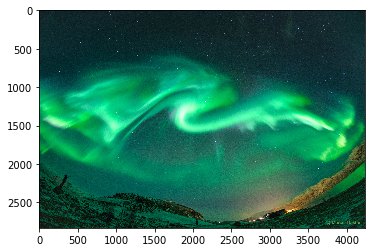

In [12]:
image_path = 'dragonaurora.jpg'

# Show our Final Dream Image 
img1 = image.load_img(image_path)
plt.imshow(img1);

##This is the input image of an Aurora

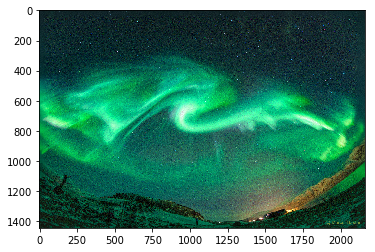

In [11]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

image_path = 'dream_at_scale_(1444, 2163).png'

# Show our Final Dream Image 
img1 = image.load_img(image_path)
plt.imshow(img1);


In [ ]:
#The image above is generated after applying the deepdream filters.